In [1]:
import os, sys, re, datetime, copy
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
from collections import OrderedDict
radex_calc_path = os.path.join(os.path.dirname(os.getcwd()), 'tmp', 'calc_radex_disky') # 'calc_radex'

In [2]:
# User-defined global parameters

if __name__ == '__main__' and '__file__' not in globals():
    
    %run calc_LTE_R_CI10CO21_varying_N_CO_T_kin.ipynb
    
list_of_X_CICO = np.concatenate([[0.05], np.arange(0.1, 1.0, 0.1), np.arange(1.0, 3.0+0.2, 0.2)]) # disky

list_of_lognH2_for_N_repISM = np.array([2.5, 2.5, 2.5, 3.0, 3.0, 3.0, 3.0])

out_fig_name = 'Plot_RADEX_R_CI10CO21_sim_XCICO'


list_of_alphaCO10_for_N_repISM [3.500, 2.000, 0.941, 0.889, 1.025, 0.780, 0.714]
list_of_Sigma_H2_for_N_repISM [102.941, 220.588, 294.118, 588.235, 640.414, 687.798, 1102.941]
list_of_Sigma_mol_for_N_repISM [140.000, 300.000, 400.000, 800.000, 870.964, 935.406, 1500.000]
list_of_N_H2_for_N_repISM [6.424e+21, 1.376e+22, 1.835e+22, 3.671e+22, 3.996e+22, 4.292e+22, 6.882e+22]
list_of_Sigma_mol_range_for_N_repISM [[ 105.          175.        ]
 [ 200.          400.        ]
 [ 329.41176471  470.58823529]
 [ 711.11111111  888.88888889]
 [ 717.26413291 1024.66304701]
 [ 779.50472846 1091.30661984]
 [1428.57142857 1571.42857143]]


In [3]:
# Define functions to read the pre-calculated tables by "calc_NonLTE_RADEX_sim_XCICO.ipynb"

def format_lookup_key(X_CICO, d_V):
    if X_CICO < 0.1:
        X_CICO_str = '{:.2f}'.format(X_CICO)
    else:
        X_CICO_str = '{:.1f}'.format(X_CICO)
    if d_V < 0.1:
        d_V_str = '{:.2f}'.format(d_V)
    else:
        d_V_str = '{:.1f}'.format(d_V)
    return f'XCICO_{X_CICO_str}_dv_{d_V_str}kms'

def get_data_table_by_X_CICO_d_V(input_X_CICO, 
                                 input_d_V, 
                                 data_table_lookup_dict = None, 
                                 radex_calc_path = None, 
                                 check_T_kin_in_table = None, 
                                 verbose = True, 
    ):
    # prepare lookup_key which is part of the data table file name
    lookup_key = format_lookup_key(input_X_CICO, input_d_V)
    if verbose:
        print('lookup_key', lookup_key)
    # find data table file
    data_table = None
    if isinstance(data_table_lookup_dict, (dict, OrderedDict)):
        if lookup_key in data_table_lookup_dict:
            data_table = data_table_lookup_dict[lookup_key]
    if data_table is None:
        data_table_name = 'out_table_RADEX_R_CI10CO21_sim_' + lookup_key
        data_table_file = data_table_name + '.csv'
        if radex_calc_path is not None:
            data_table_file = os.path.join(radex_calc_path, 
                                           data_table_file)
        if not os.path.isfile(data_table_file):
            raise Exception('Error! File not found: "{}"! '.format(data_table_file) + 
                            'Run "calc_NonLTE_RADEX_sim_XCICO" first!')
        if verbose:
            print('Reading "%s"'%(data_table_file))
        data_table = Table.read(data_table_file, format='csv')
        if isinstance(data_table_lookup_dict, (dict, OrderedDict)):
            data_table_lookup_dict[lookup_key] = data_table
    # check T_kin in table
    if check_T_kin_in_table is not None:
        if not isinstance(check_T_kin_in_table, (list, tuple)):
            check_T_kin_in_table = [check_T_kin_in_table]
        for T_kin in check_T_kin_in_table:
            uniq_T_kin = np.unique(data_table['T_kin'].data)
            if not np.any(np.isclose(T_kin, uniq_T_kin)):
                raise Exception('Error! T_kin {} not in table {}!'.format(T_kin, str(uniq_T_kin)))
    # return
    return data_table


In [4]:
# Define function to read x y from table

data_table_lookup_dict = {}

def read_X_CICO_R_CICO_from_table(
        N_CO, 
        d_V, 
        T_kin, 
        n_H2, 
        LTE = False, 
        verbose = False, 
    ):
    
    global data_table_lookup_dict
    global radex_calc_path
    global list_of_X_CICO
    
    x, y, mask_CO_opt_thin, mask_CI_opt_thin = None, None, None, None
    
    for X_CICO in list_of_X_CICO:
        
        in_table = get_data_table_by_X_CICO_d_V(
            X_CICO, 
            d_V, 
            data_table_lookup_dict = data_table_lookup_dict, 
            radex_calc_path = radex_calc_path, 
            verbose = verbose, 
        )
        #print(in_table.colnames)
    
        #print('T_kin:', np.unique(in_table['T_kin'].data))

        if LTE:
            colsuffix = '_LTE'
        else:
            colsuffix = '_NonLTE'

        select_by_N_CO_T_kin = np.logical_and.reduce((
                np.isclose(np.log10(in_table['N_CO']), np.log10(N_CO), rtol=0.0, atol=0.005), 
                np.isclose(np.log10(in_table['n_H2']), np.log10(n_H2), rtol=0.0, atol=0.005), 
                np.isclose(in_table['T_kin'], T_kin, rtol=0.0, atol=0.5), 
            ))
        
        if np.count_nonzero(select_by_N_CO_T_kin) > 0:
            if x is None:
                x = in_table['X_CICO'][select_by_N_CO_T_kin]
                y = in_table['R_CI10CO21'+colsuffix][select_by_N_CO_T_kin]
                mask_CO_opt_thin = in_table['tau_0_CO21'+colsuffix][select_by_N_CO_T_kin]<1.
                mask_CI_opt_thin = in_table['tau_0_CI10'+colsuffix][select_by_N_CO_T_kin]<1.
            else:
                tmp_x = in_table['X_CICO'][select_by_N_CO_T_kin]
                tmp_y = in_table['R_CI10CO21'+colsuffix][select_by_N_CO_T_kin]
                tmp_mask_CO_opt_thin = in_table['tau_0_CO21'+colsuffix][select_by_N_CO_T_kin]<1.
                tmp_mask_CI_opt_thin = in_table['tau_0_CI10'+colsuffix][select_by_N_CO_T_kin]<1.
                x = np.concatenate([x, tmp_x])
                y = np.concatenate([y, tmp_y])
                mask_CO_opt_thin = np.concatenate([mask_CO_opt_thin, tmp_mask_CO_opt_thin])
                mask_CI_opt_thin = np.concatenate([mask_CI_opt_thin, tmp_mask_CI_opt_thin])
    
    #print('read_X_CICO_R_CICO_from_table NonLTE. x is None ? {}. y is None ? {}'.format(x is None, y is None))
    
    return x, y, mask_CO_opt_thin, mask_CI_opt_thin

if __name__ == '__main__' and '__file__' not in globals():
    
    read_X_CICO_R_CICO_from_table(N_CO = list_of_N_CO[0], 
                                  d_V = list_of_d_V_for_N_repISM[0], 
                                  T_kin = list_of_T_kin_for_N_repISM[0], 
                                  n_H2 = 3.16e2, 
                                  verbose = True, 
                                 )


lookup_key XCICO_0.05_dv_3.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.05_dv_3.0kms.csv"
lookup_key XCICO_0.1_dv_3.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.1_dv_3.0kms.csv"
lookup_key XCICO_0.2_dv_3.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_3.0kms.csv"
lookup_key XCICO_0.3_dv_3.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.3_dv_3.0kms.csv"
lookup_key XCICO_0.4_dv_3.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.4_dv_3.0kms.csv"
lookup_key XCICO_0.5_dv_3.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/

In [5]:
# test

if __name__ == '__main__' and '__file__' not in globals():
    
    read_X_CICO_R_CICO_from_table(N_CO = list_of_N_CO[-1], 
                                  d_V = list_of_d_V_for_N_repISM[-1], 
                                  T_kin = list_of_T_kin_for_N_repISM[-1], 
                                  n_H2 = 3.16e2, 
                                  verbose = True, 
                                 )


lookup_key XCICO_0.05_dv_90.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.05_dv_90.0kms.csv"
lookup_key XCICO_0.1_dv_90.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.1_dv_90.0kms.csv"
lookup_key XCICO_0.2_dv_90.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_90.0kms.csv"
lookup_key XCICO_0.3_dv_90.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.3_dv_90.0kms.csv"
lookup_key XCICO_0.4_dv_90.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.4_dv_90.0kms.csv"
lookup_key XCICO_0.5_dv_90.0kms
Reading "/Users/dzliu/Work/2020

vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.07, highlight_x2 0.12, highlight_y1 17.90, highlight_y2 17.69, highlight_ry1 174.2, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.13, highlight_x2 0.26, highlight_y1 18.26, highlight_y2 17.97, highlight_ry1 398.6, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

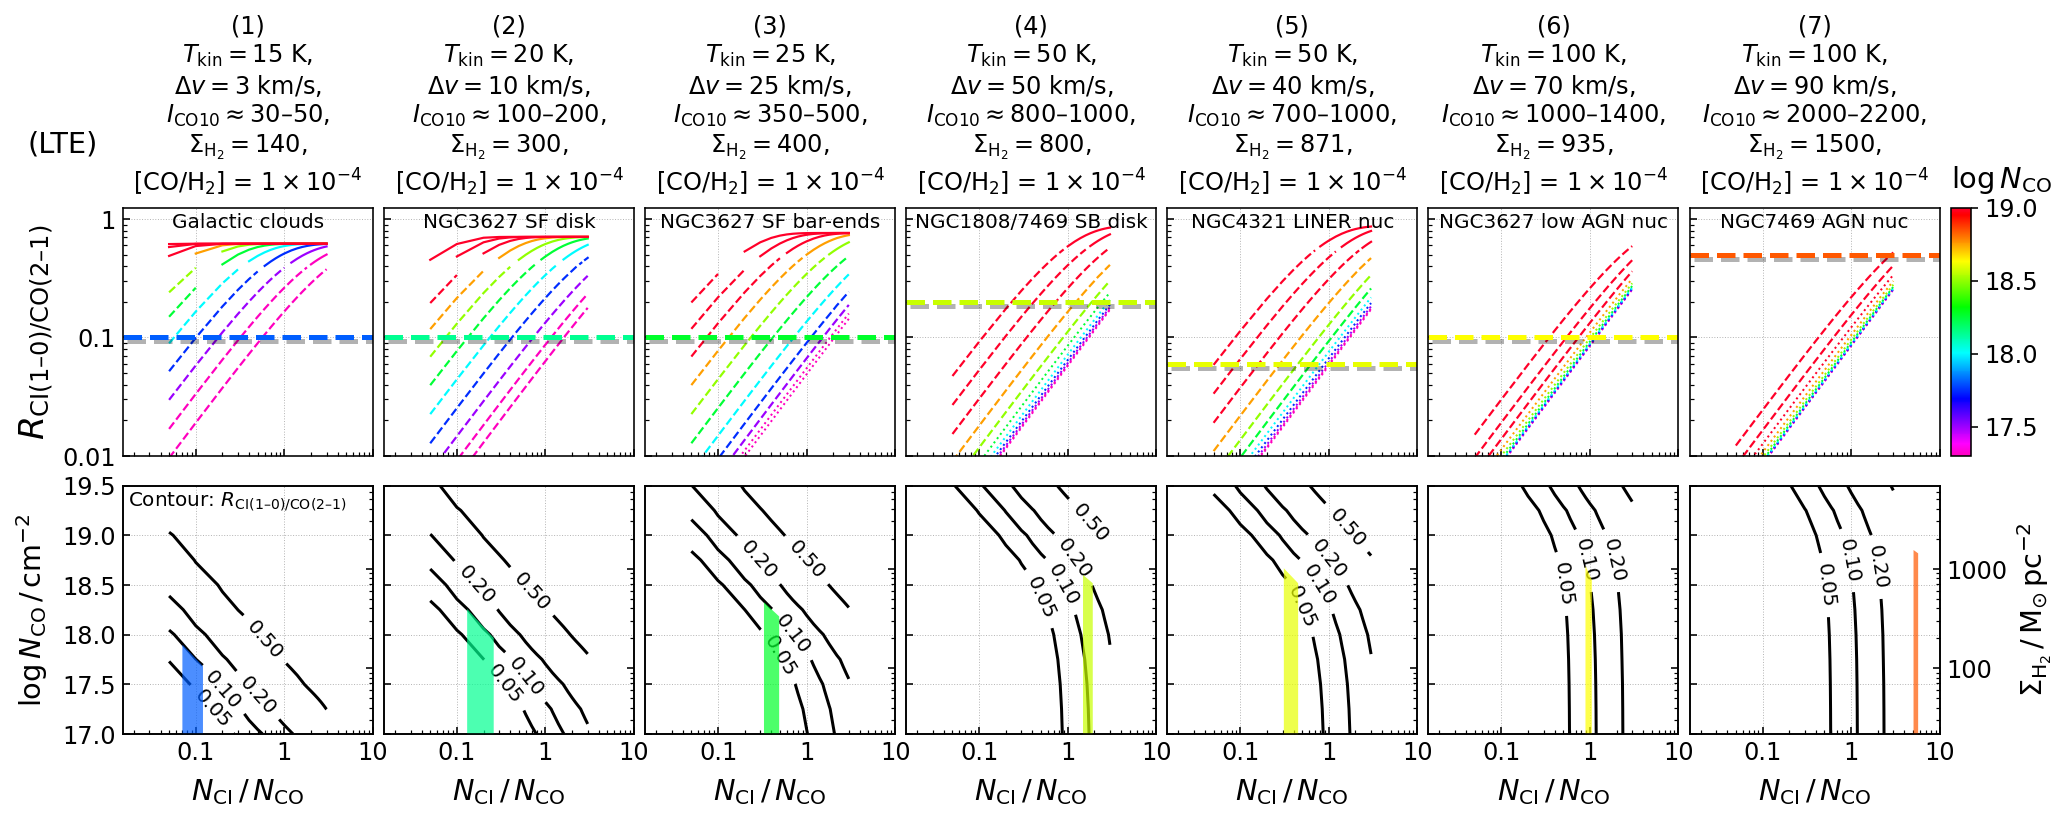

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():
    
    fig = make_a_figure(
            out_figure_file = out_fig_name + '_LTE_varying_N_CO_T_kin.pdf', 
            n_H2 = 3.16e2, 
            LTE = True, 
        )


vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.16, highlight_x2 0.25, highlight_y1 17.90, highlight_y2 17.69, highlight_ry1 174.2, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.19, highlight_x2 0.31, highlight_y1 18.26, highlight_y2 17.97, highlight_ry1 398.6, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

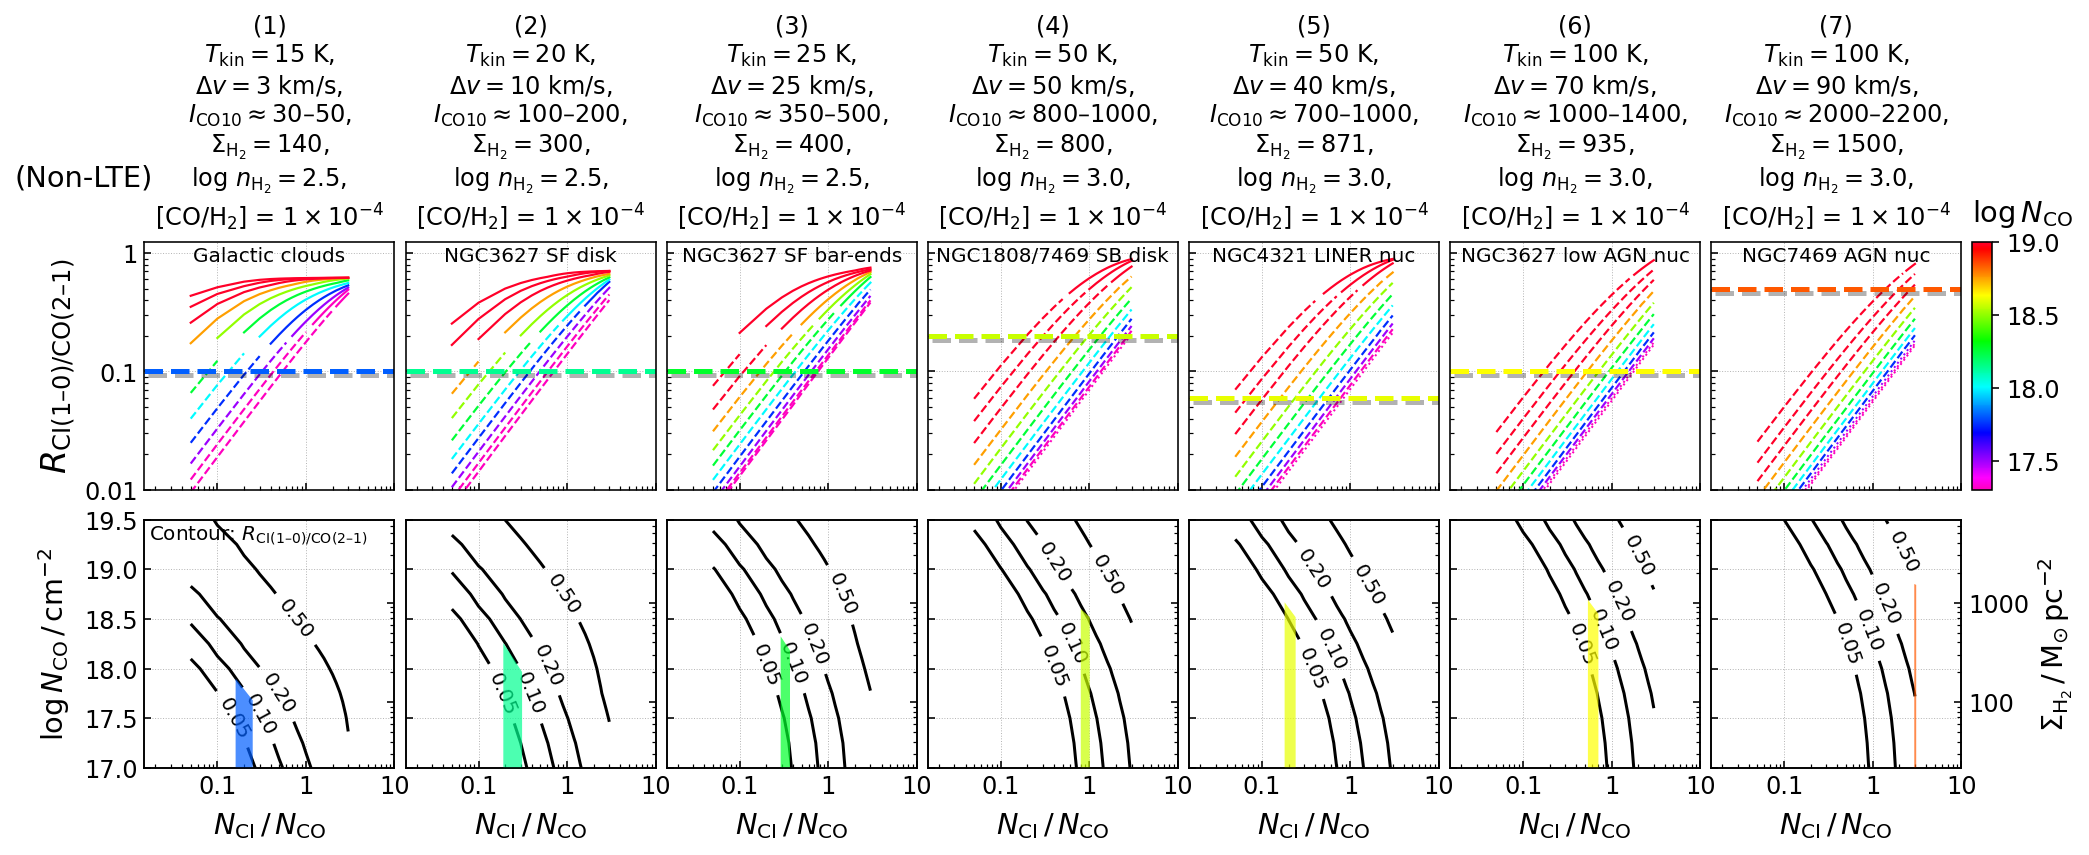

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():
    
    fig = make_a_figure(
            out_figure_file = out_fig_name + '_NonLTE_varying_N_CO_T_kin_n_H2.pdf', 
            list_of_n_H2 = 10**list_of_lognH2_for_N_repISM, 
            LTE = False, 
        )


vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.28, highlight_x2 0.40, highlight_y1 17.90, highlight_y2 17.69, highlight_ry1 174.2, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.29, highlight_x2 0.41, highlight_y1 18.26, highlight_y2 17.97, highlight_ry1 398.6, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

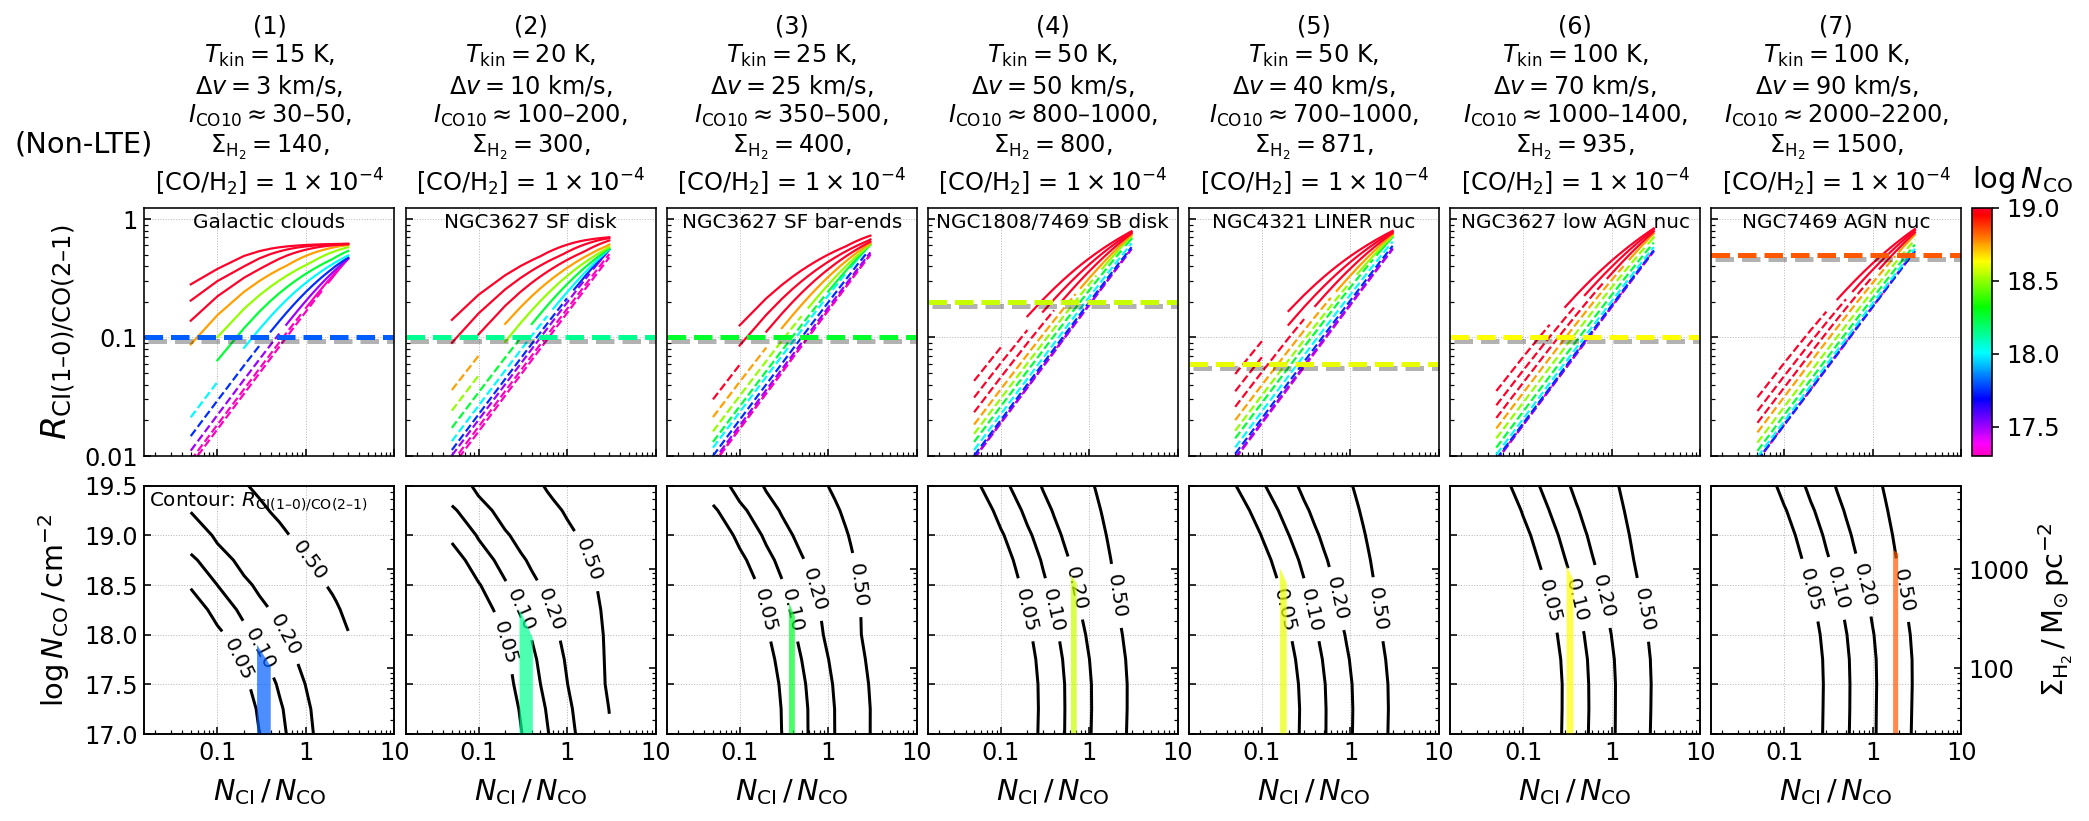

In [8]:
if __name__ == '__main__' and '__file__' not in globals():
    
    fig = make_a_figure(
            out_figure_file = out_fig_name + '_NonLTE_nH2_1e2_varying_N_CO_T_kin.pdf', 
            n_H2 = 1e2, 
            LTE = False, 
        )


vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.16, highlight_x2 0.25, highlight_y1 17.90, highlight_y2 17.69, highlight_ry1 174.2, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.19, highlight_x2 0.31, highlight_y1 18.26, highlight_y2 17.97, highlight_ry1 398.6, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

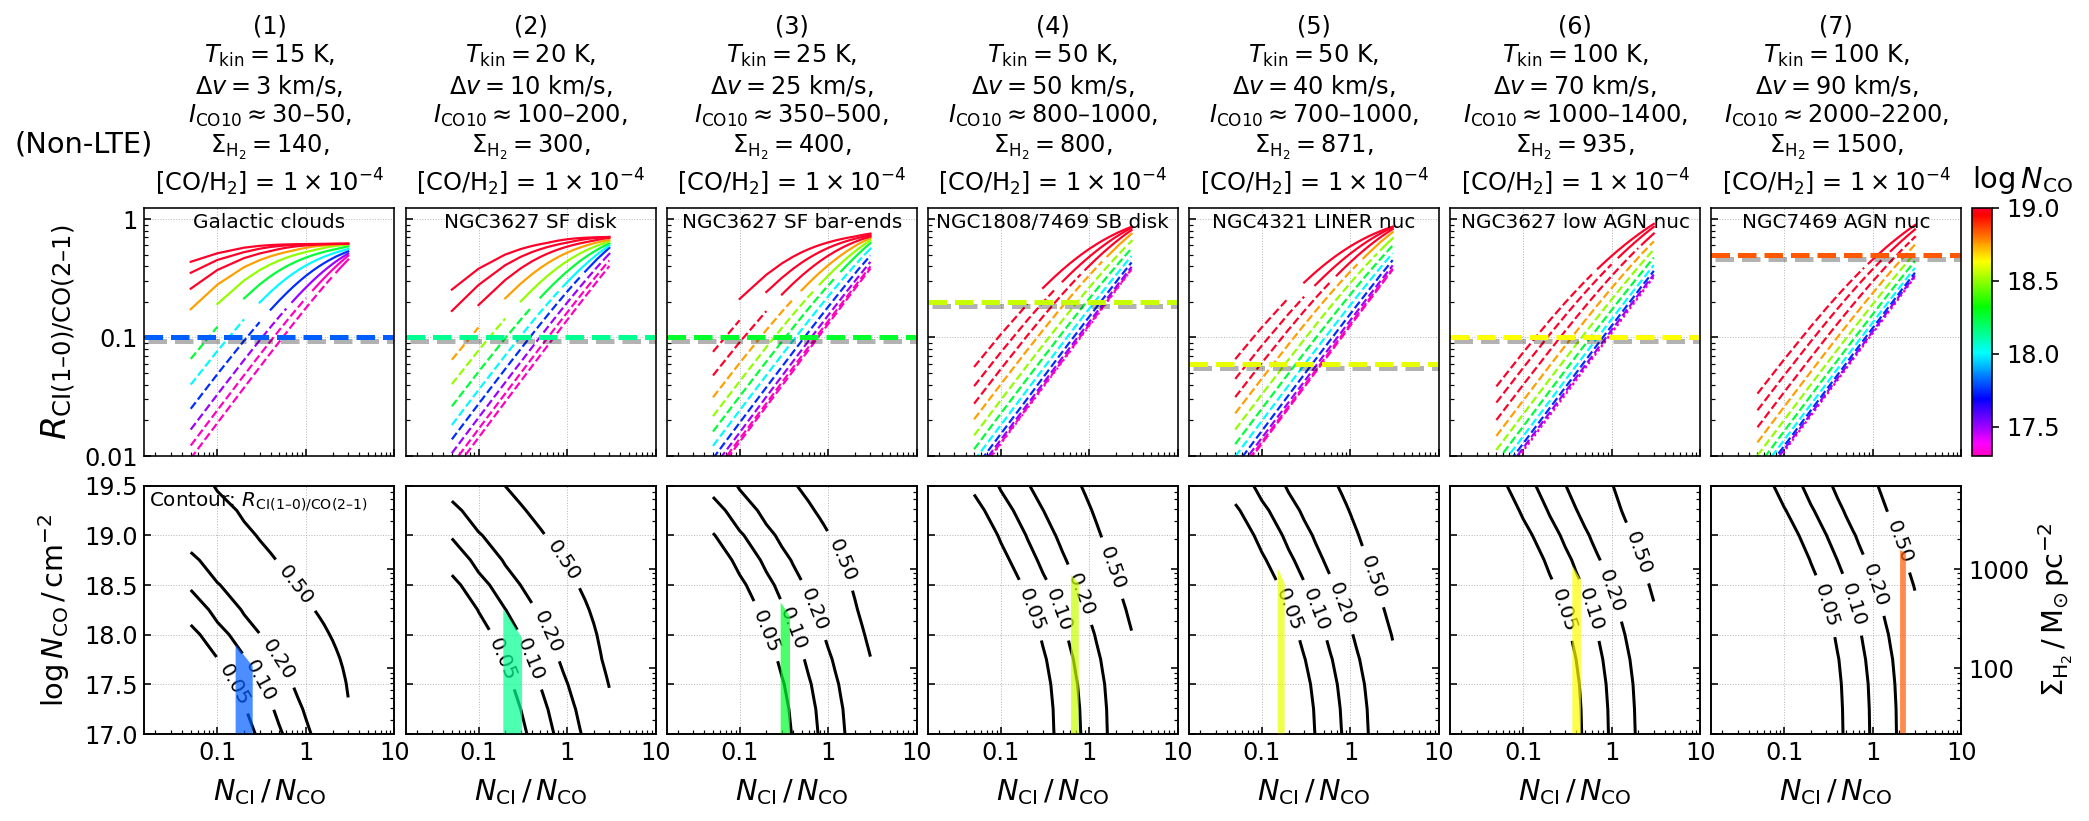

In [9]:
if __name__ == '__main__' and '__file__' not in globals():
    
    fig = make_a_figure(
            out_figure_file = out_fig_name + '_NonLTE_nH2_3.16e2_varying_N_CO_T_kin.pdf', 
            n_H2 = 3.16e2, 
            LTE = False, 
        )


vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.10, highlight_x2 0.16, highlight_y1 17.90, highlight_y2 17.69, highlight_ry1 174.2, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.15, highlight_x2 0.27, highlight_y1 18.26, highlight_y2 17.97, highlight_ry1 398.6, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

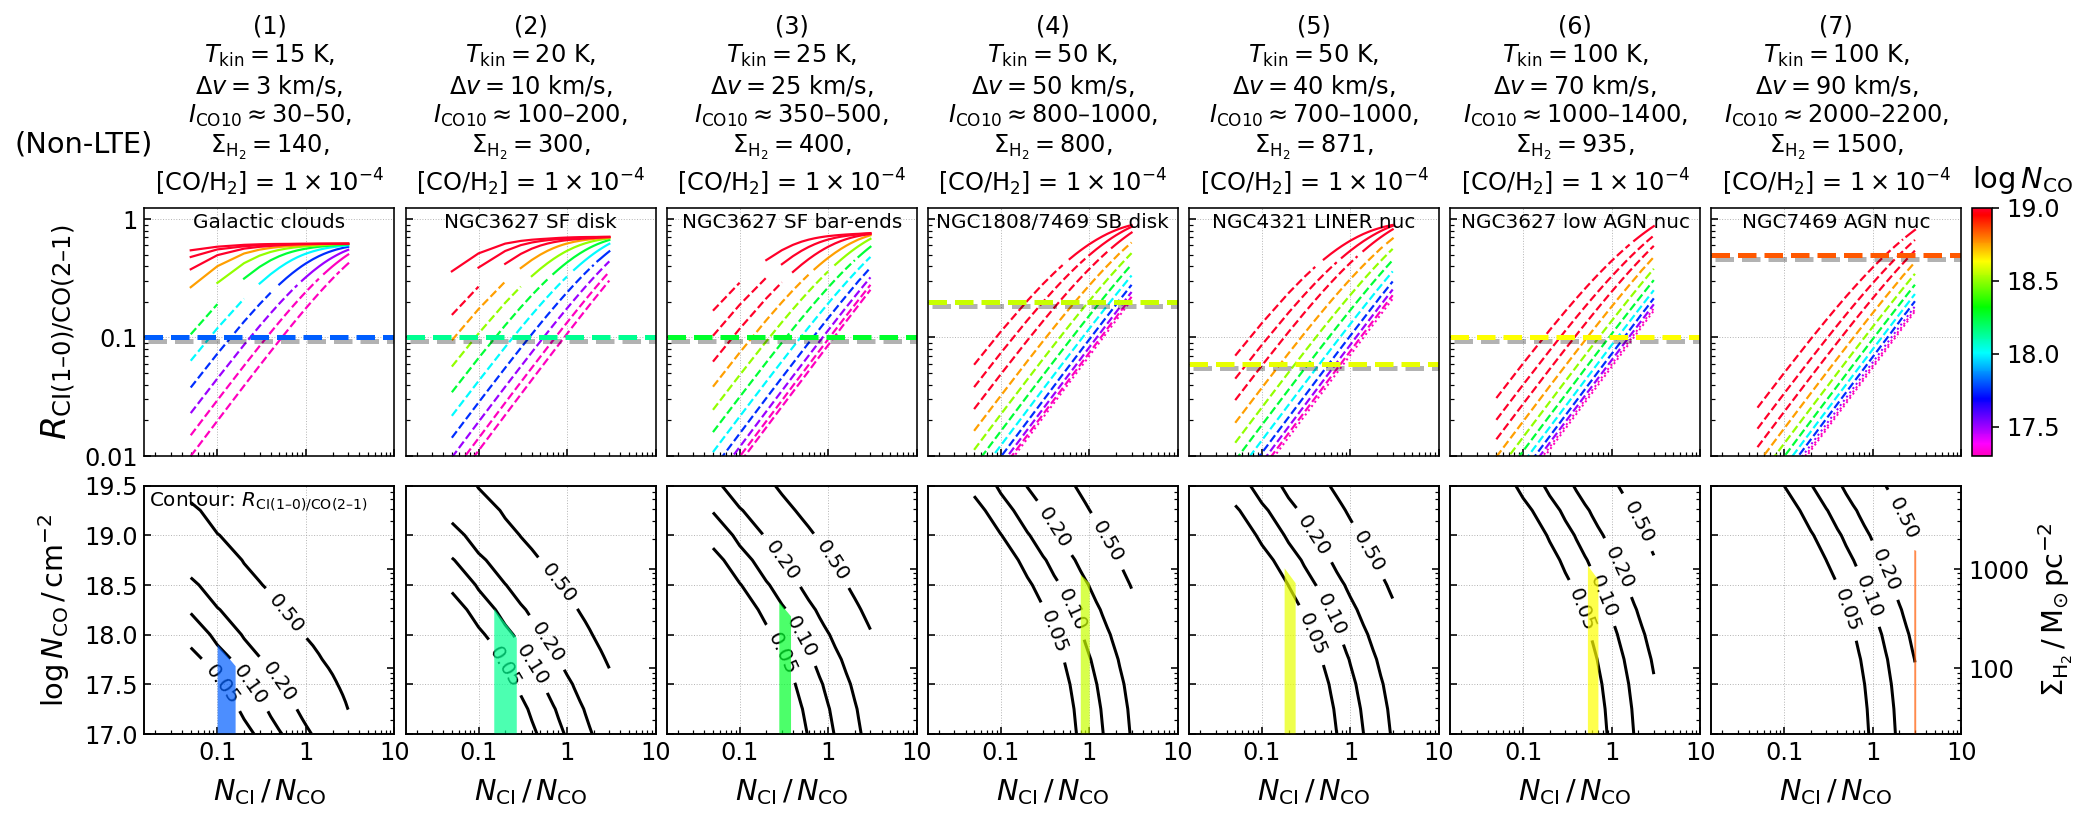

In [10]:
if __name__ == '__main__' and '__file__' not in globals():
    
    fig = make_a_figure(
            out_figure_file = out_fig_name + '_NonLTE_nH2_1e3_varying_N_CO_T_kin.pdf', 
            n_H2 = 1e3, 
            LTE = False, 
        )


vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.08, highlight_x2 0.13, highlight_y1 17.90, highlight_y2 17.69, highlight_ry1 174.2, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.13, highlight_x2 0.26, highlight_y1 18.26, highlight_y2 17.97, highlight_ry1 398.6, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

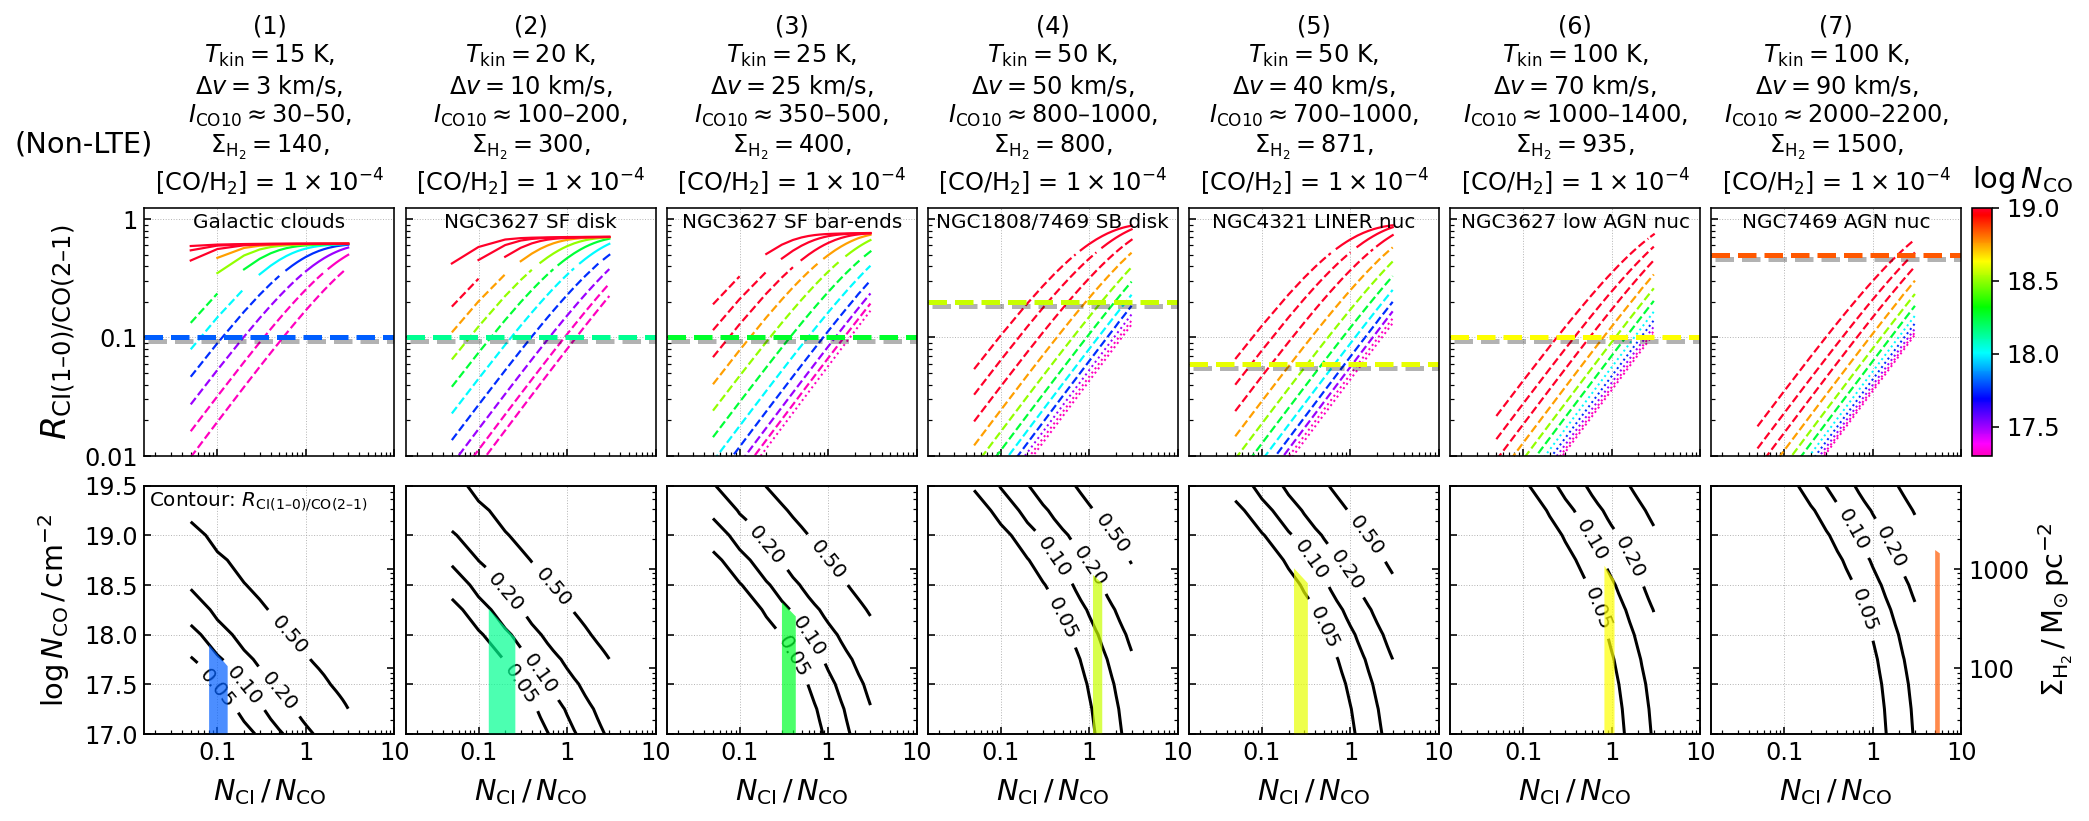

In [11]:
if __name__ == '__main__' and '__file__' not in globals():
    
    fig = make_a_figure(
            out_figure_file = out_fig_name + '_NonLTE_nH2_3.16e3_varying_N_CO_T_kin.pdf', 
            n_H2 = 3.16e3, 
            LTE = False, 
        )


vmin 17.3, vmax 19.0
--
panel 1, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (30.0, 50.0), alphaCO10 3.50, 
Sigma_mol_range [105. 175.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.68 17.9 ] highlight_N_CO_mean_log10 17.81 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 0.3697783461210571, 1.0, 1.0)
highlight_x1 0.07, highlight_x2 0.12, highlight_y1 17.90, highlight_y2 17.69, highlight_ry1 174.2, highlight_ry2 105.6
--
panel 2, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (100.0, 200.0), alphaCO10 2.00, 
Sigma_mol_range [200. 400.] vs. right axis y range [  21.78 6887.21]
highlight_N_CO_range_log10 [17.96 18.26] highlight_N_CO_mean_log10 18.14 vs. left axis y range [17.  19.5]
highlight_line_color (0.0, 1.0, 0.5692599620493359, 1.0)
highlight_x1 0.13, highlight_x2 0.26, highlight_y1 18.26, highlight_y2 17.97, highlight_ry1 398.6, highlight_ry2 203.2
--
panel 3, CO_abundance 1.0e-04, R_CI10CO21 0.1, I_CO10_range (350.0, 500.0), alphaC

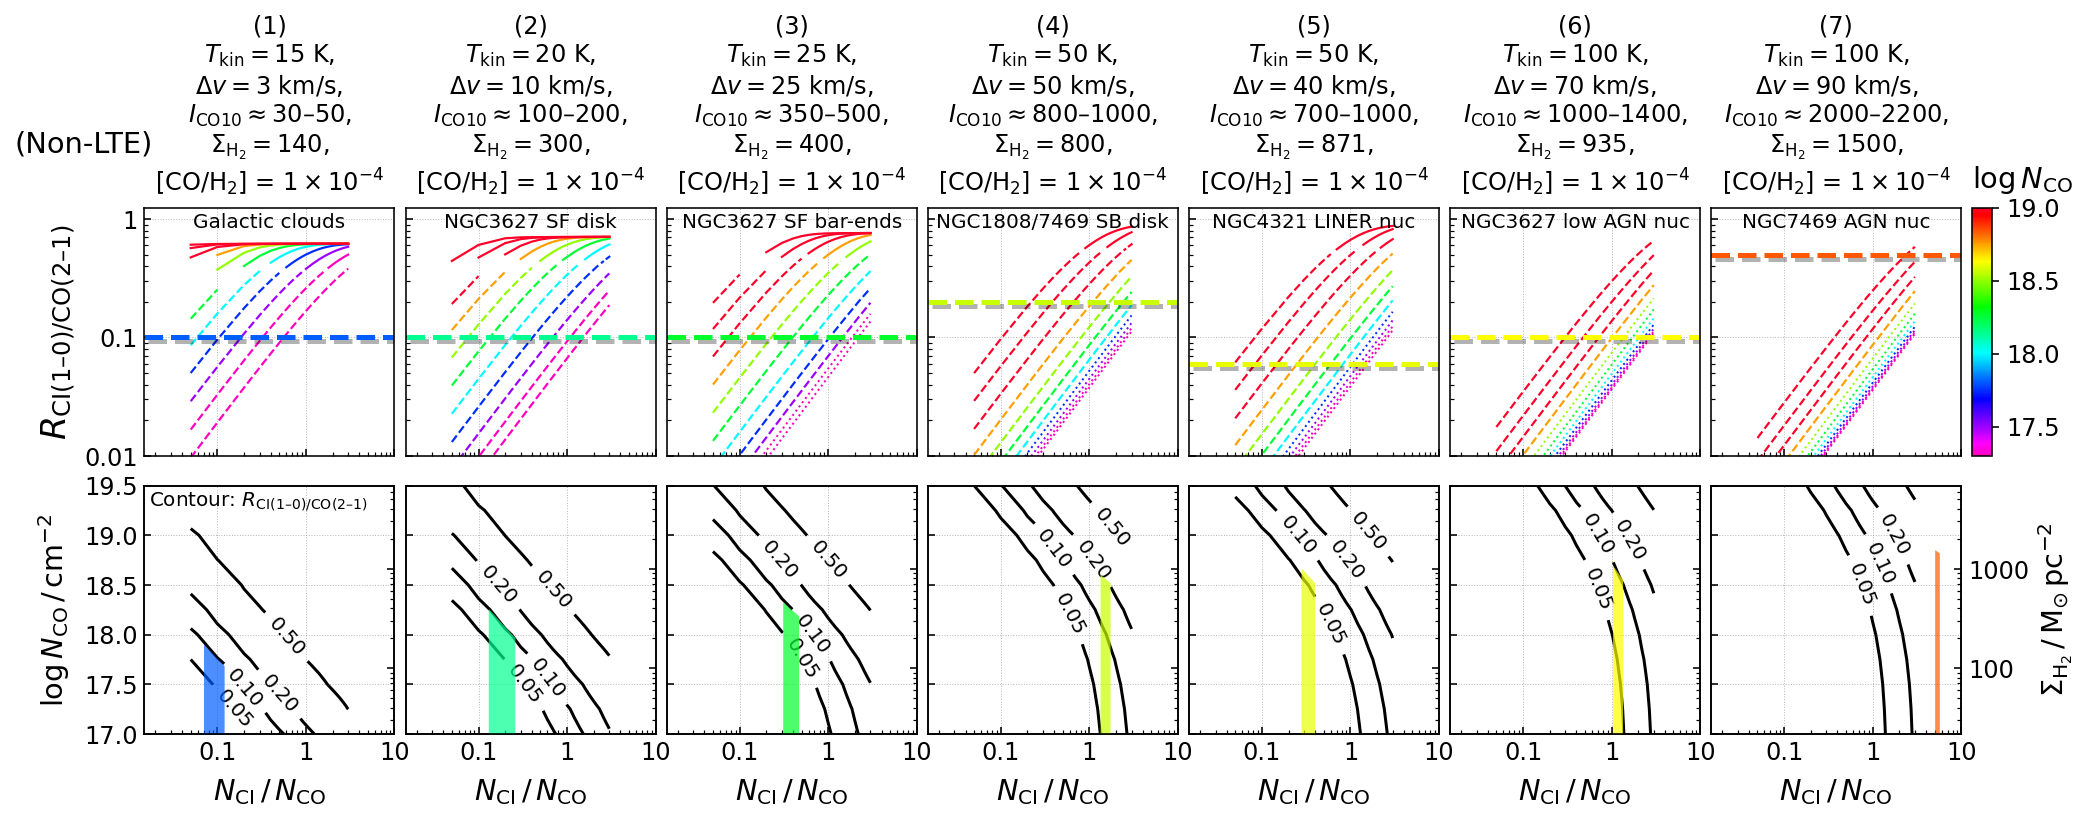

In [12]:
if __name__ == '__main__' and '__file__' not in globals():
    
    fig = make_a_figure(
            out_figure_file = out_fig_name + '_NonLTE_nH2_1e4_varying_N_CO_T_kin.pdf', 
            n_H2 = 1e4, 
            LTE = False, 
        )


In [13]:
# if __name__ == '__main__' and '__file__' not in globals():
    
#     fig = make_a_figure(
#             out_figure_file = out_fig_name + '_NonLTE_nH2_1e5_varying_N_CO_T_kin.pdf', 
#             n_H2 = 1e5, 
#             LTE = False, 
#         )


In [14]:
# if __name__ == '__main__' and '__file__' not in globals():
    
#     fig = make_a_figure(
#             out_figure_file = out_fig_name + '_NonLTE_nH2_1e6_varying_N_CO_T_kin.pdf', 
#             n_H2 = 1e6, 
#             LTE = False, 
#         )
